In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics.cluster import contingency_matrix
from scanofc import Clustering, NetworkInference
mpl.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'

In [2]:
def simulate_cluster_means_1(size, time_points, func, random_gen=None):
    """
    Simulates means for a given cluster for the first series of simulation
    studies.

    Parameters
    ----------
    size : int
        Number of members in the cluster.
    time_points : array-like
        1D array-like containing data with `float` type, representing time
        points for the simulated dataset.
    func : int (1, 2, 3 or 4)
        Indicates a simulation model for cluster means, different models
        generate different clusters. Each model is based on a polynomial with
        random coefficients.
    random_gen : RandomState instance or None, optional
        Random number generator, used to reproduce results. If None (default),
        the generator is the RandomState instance used by `np.random`.
        If RandomState instance, random_gen is the actual random
        number generator.

    Returns
    -------
    sim_clust_means : ndarray
        2D array of shape (len(time_points), size) containing data
        with `float` type, representing fold changes' means for each simulated
        entity and each time point.

    """
    nb_time_p = len(time_points)
    time_rep = np.repeat(time_points, size).reshape(nb_time_p, size)
    if random_gen is None:
        random_gen = np.random
    if func == 1:
        # Model with a 2-degree polynomial
        def func_1(x, a, b, c): return a*x**2/2 + b * x + c
        a = np.repeat(0.005*random_gen.randn(size)+0.05,
                      nb_time_p).reshape(size, nb_time_p).T
        b = np.repeat(2 * a[0, :] * random_gen.randn(size) -
                      10 * a[0, :], nb_time_p).reshape(size, nb_time_p).T
        c = np.repeat(random_gen.randn(size) + 2,
                      nb_time_p).reshape(size, nb_time_p).T
        sim_clust_means = func_1(time_rep, a, b, c)
    if func in (2, 3):
        # Models with 3-degree polynomials (increasing and decreasing)
        def func_2(x, a, r1, r2, c, d): return (a*x**3/3 - x**2 * a * (r1 + r2)/2
                                                + x * a * r1 * r2 + c * x + d)
        r1 = np.repeat(random_gen.randn(size) + 5,
                       nb_time_p).reshape(size, nb_time_p).T
        r2 = np.repeat(random_gen.randn(size) + 15,
                       nb_time_p).reshape(size, nb_time_p).T
        if func == 3:
            a = np.repeat(0.001 * random_gen.randn(size) + 0.01,
                          nb_time_p).reshape(size, nb_time_p).T
            d = np.repeat(random_gen.randn(size) + 3,
                          nb_time_p).reshape(size, nb_time_p).T
        else:
            a = np.repeat(0.001 * random_gen.randn(size) - 0.01,
                          nb_time_p).reshape(size, nb_time_p).T
            d = np.repeat(random_gen.randn(size) + 2,
                          nb_time_p).reshape(size, nb_time_p).T
        c = np.repeat(2 * a[0, :] * random_gen.randn(size) +
                      6 * a[0, :], nb_time_p).reshape(size, nb_time_p).T
        sim_clust_means = func_2(time_rep, a, r1, r2, c, d)
    if func == 4:
        # Model with a 4-degree polynomial
        def func_4(x, a, r1, r2, r3, b, c): return (a * (x**4/4 + x**3 * (-r1-r2-r3)/3
                                                         + x**2 *
                                                         (r1 * r2 + r3 *
                                                          (r1 + r2))/2
                                                         - x * r1 * r2 * r3) + b * x + c)
        r1 = np.repeat(0.2*random_gen.randn(size)+2,
                       nb_time_p).reshape(size, nb_time_p).T
        r2 = np.repeat(0.5*random_gen.randn(size)+10,
                       nb_time_p).reshape(size, nb_time_p).T
        r3 = np.repeat(0.2*random_gen.randn(size)+18,
                       nb_time_p).reshape(size, nb_time_p).T
        a = np.repeat(5e-5*random_gen.randn(size)+5e-3,
                      nb_time_p).reshape(size, nb_time_p).T
        b = np.repeat(random_gen.uniform(-0.05, 0.05, size),
                      nb_time_p).reshape(size, nb_time_p).T
        c = np.repeat(0.5*random_gen.randn(size)+2,
                      nb_time_p).reshape(size, nb_time_p).T
        sim_clust_means = func_4(time_rep, a, r1, r2, r3, b, c)
    return sim_clust_means


def simulate_cluster_means_2(size, time_points, func, random_gen=None):
    """
    Simulates means for a given cluster for the second series of simulation
    studies (with horizontal shifts).

    Parameters
    ----------
    size : int
        Number of members in the cluster.
    time_points : array-like
        1D array-like containing data with `float` type, representing time
        points for the simulated dataset.
    func : int (1, 2, 3 or 4)
        Indicates a simulation model for cluster means, different models
        generate different clusters. Each model is based on a polynomial
        (except 4 which is sine-based) with random coefficients.
    random_gen : RandomState instance or None, optional
        Random number generator, used to reproduce results. If None (default),
        the generator is the RandomState instance used by `np.random`.
        If RandomState instance, random_gen is the actual random
        number generator.

    Returns
    -------
    sim_clust_means_unaligned : ndarray
        2D array of shape (len(time_points), size) containing data
        with `float` type, representing unaligned fold changes' means for each
        simulated entity and each time point.
    sim_clust_means_aligned : ndarray
        2D array of shape (len(time_points), size) containing data
        with `float` type, representing aligned fold changes' means for each
        simulated entity and each time point.

    """
    nb_time_p = len(time_points)
    time_rep = np.repeat(time_points, size).reshape(nb_time_p, size)
    if random_gen is None:
        random_gen = np.random
    if func == 1:
        # Model with a 2-degree polynomial
        def func_1(x, a, b, c, s): return (
            a * (x - s) ** 2/2 + b * (x - s) + c)
        a = np.repeat(0.002*random_gen.randn(size)+0.05,
                      nb_time_p).reshape(size, nb_time_p).T
        b = np.repeat(a[0, :] * random_gen.randn(size) - 11 *
                      a[0, :], nb_time_p).reshape(size, nb_time_p).T
        c = np.repeat(0.5 * random_gen.randn(size) + 2,
                      nb_time_p).reshape(size, nb_time_p).T
        w = 10
        s = random_gen.uniform(-w, w, size)
        sim_clust_means_unaligned = func_1(time_rep, a, b, c, s)
        sim_clust_means_aligned = func_1(time_rep, a, b, c, np.zeros(size))
    if func in (2, 3):
        # Models with 3-degree polynomials (increasing and decreasing)
        def func_2(x, a, r1, r2, c, d, s): return (a * (x - s) ** 3/3
                                                   - (x - s) ** 2 *
                                                   a * (r1 + r2)/2
                                                   + (x - s) * a * r1 * r2
                                                   + c * (x - s) + d)
        r1 = np.repeat(random_gen.randn(size) + 8,
                       nb_time_p).reshape(size, nb_time_p).T
        r2 = np.repeat(random_gen.randn(size) + 12,
                       nb_time_p).reshape(size, nb_time_p).T
        if func == 3:
            a = np.repeat(1e-5 * random_gen.randn(size) + 0.003,
                          nb_time_p).reshape(size, nb_time_p).T
            d = np.repeat(0.5*random_gen.randn(size) + 2,
                          nb_time_p).reshape(size, nb_time_p).T
        else:
            a = np.repeat(1e-5 * random_gen.randn(size) - 0.003,
                          nb_time_p).reshape(size, nb_time_p).T
            d = np.repeat(0.5*random_gen.randn(size) + 3,
                          nb_time_p).reshape(size, nb_time_p).T
        c = np.repeat(2 * a[0, :] * random_gen.randn(size) +
                      6 * a[0, :], nb_time_p).reshape(size, nb_time_p).T
        w = 10
        s = random_gen.uniform(-w, w, size)
        sim_clust_means_unaligned = func_2(time_rep, a, r1, r2, c, d, s)
        sim_clust_means_aligned = func_2(
            time_rep, a, r1, r2, c, d, np.zeros(size))
    if func == 4:
        # Model with a sine-based function
        def func_4(x, a, b, c, s): return a * np.sin(b * (x-s)) + c
        w = 7
        s = random_gen.uniform(-w, w, size)
        a = np.abs(np.repeat(random_gen.randn(size)+2,
                   nb_time_p).reshape(size, nb_time_p).T)
        b = np.repeat(random_gen.uniform(0.3, 0.5, size),
                      nb_time_p).reshape(size, nb_time_p).T
        c = np.repeat(0.5*random_gen.randn(size) + 2,
                      nb_time_p).reshape(size, nb_time_p).T
        sim_clust_means_unaligned = func_4(time_rep, a, b, c, s)
        sim_clust_means_aligned = func_4(time_rep, a, b, c, np.zeros(size))
    return sim_clust_means_unaligned, sim_clust_means_aligned


def reorder_clusters(new_order, clusters, centroids=None):
    """
    Reorders cluster labels and centroids (if given) according to a given
    order. Can be used, for example, to introduce label correspondence for
    datasets with pairwise comparable clusters.

    Parameters
    ----------
    new_order : array-like
        1D vector of size k (number of clusters) representing the new order of
        clusters with respect to the old order.
    clusters : ndarray
        1D array of length nb_var containing integers indicating clusters
        to which the fold changes are assigned (in the original order).
    centroids : ndarray
        1D array of length k containing indices in range (0, nb_var) of
        the fold changes that act as centroids (in the original order).

    Returns
    -------
    clusters_new_order : ndarray
        Reordered set of cluster labels.
    centroids_new_order: ndarray (if centroids are given)
        Reordered set of centroids.

    """
    nb_var = len(clusters)
    clusters_new_order = np.zeros(nb_var, dtype=int)
    for i, no in enumerate(new_order):
        clusters_new_order = np.where(clusters == no, i, clusters_new_order)
    if centroids is not None:
        centroids_new_order = centroids[np.array(new_order)]
        return clusters_new_order, centroids_new_order
    return clusters_new_order

In [3]:
random_gen = np.random.RandomState(0)
nb_var = 300
time_points_1 = np.array([0.5,  1.,  2.,  3.,  4.,  7., 14., 21.])
nb_time_p = len(time_points_1)
sim_means_1 = np.zeros((nb_time_p, nb_var))

# Study 1: Distances & Algorithms 
### d2hat k-medoids vs Wasserstein k-means

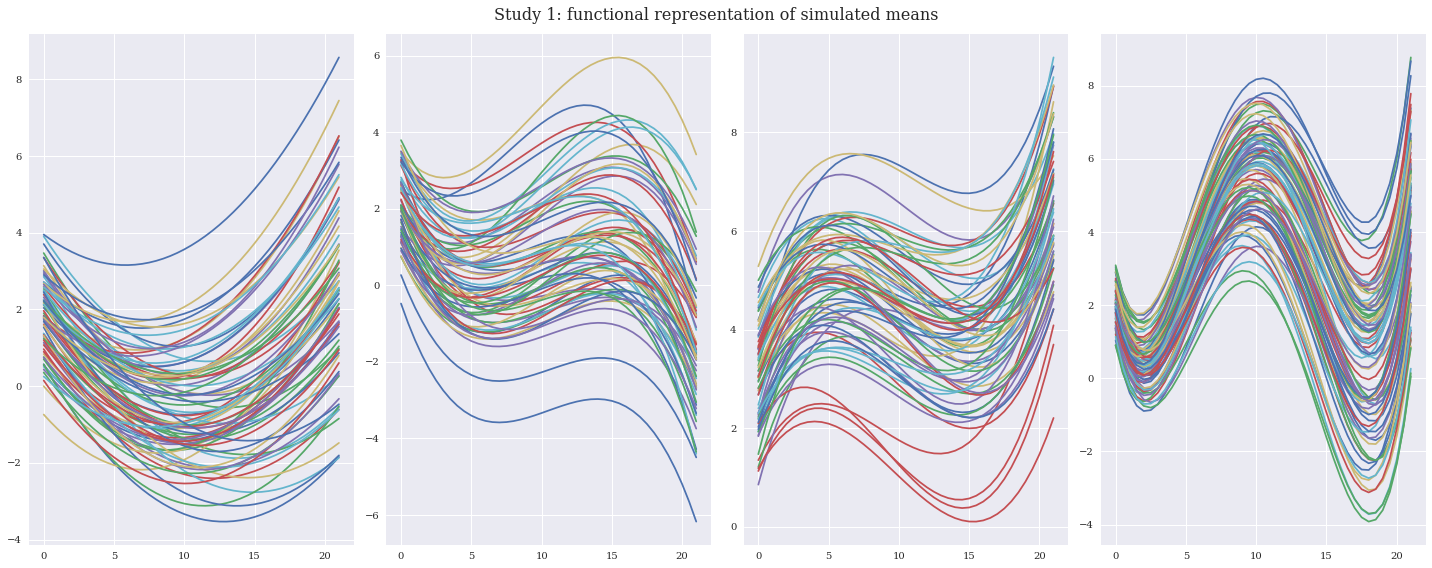

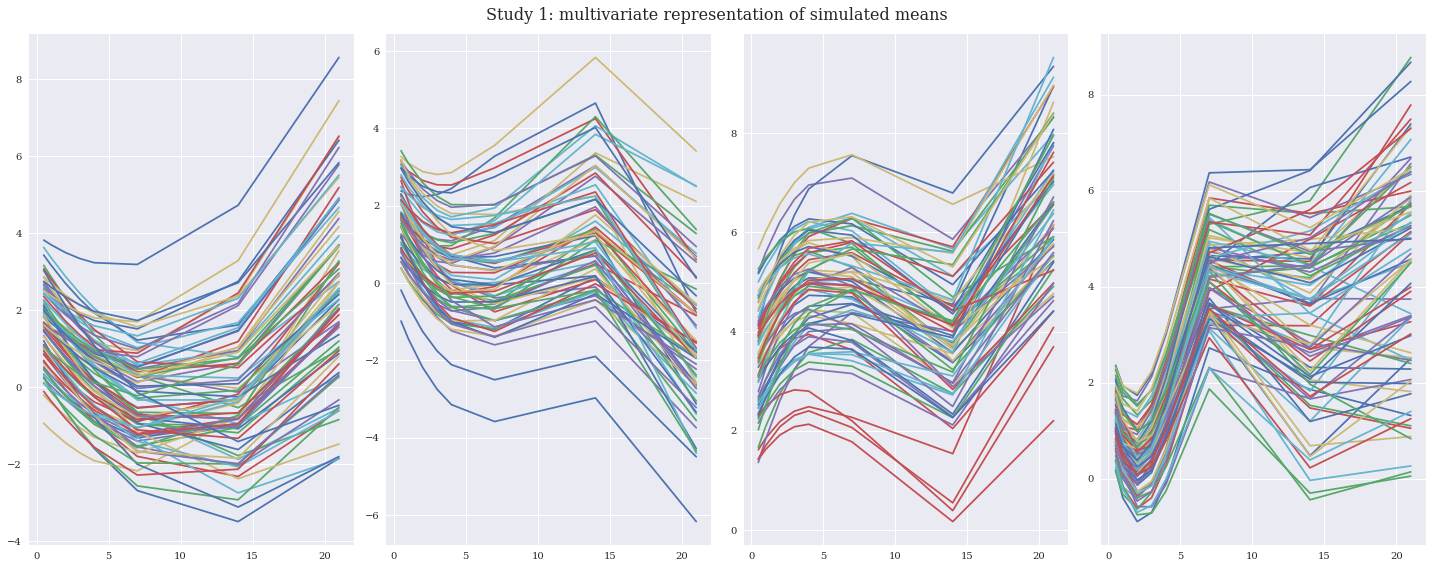

In [4]:
k = 4
sim_clusters = random_gen.choice(range(k), nb_var)
random_gen.shuffle(sim_clusters)

# Simulating means of k clusters:
plot_time_points = np.linspace(0, 21, 43)
time_p_ind_1 = np.array((1, 2, 4, 6, 8, 14, 28, 42))
fig_1, axs_1 = plt.subplots(1, k, figsize=(20, 8), sharey=False)
fig_2, axs_2 = plt.subplots(1, k, figsize=(20, 8), sharey=False)
for i, cl in enumerate(range(k)):
    cluster_i = np.argwhere(sim_clusters == cl)
    sim_means_plot_1 = simulate_cluster_means_1(cluster_i.size, plot_time_points,
                                                cl+1, random_gen=random_gen)
    axs_1[i].plot(plot_time_points, sim_means_plot_1)
    sim_means_1[:, np.squeeze(cluster_i)] = sim_means_plot_1[time_p_ind_1, :]
    axs_2[i].plot(time_points_1, sim_means_plot_1[time_p_ind_1, :])
fig_1.suptitle('Study 1: functional representation of simulated means',
               fontsize=16)
fig_1.tight_layout()
fig_2.suptitle('Study 1: multivariate representation of simulated means',
               fontsize=16)
fig_2.tight_layout()
plt.show()

In [5]:
# Simulating variances of k clusters (independent scenario):
sim_cov_1 = np.zeros((nb_time_p, nb_var, nb_var))
sim_var_1 = np.repeat(np.abs(random_gen.randn(nb_var)*2),
                      nb_time_p).reshape((nb_var, nb_time_p)).T
sim_cov_1[:, np.arange(nb_var), np.arange(nb_var)] = sim_var_1

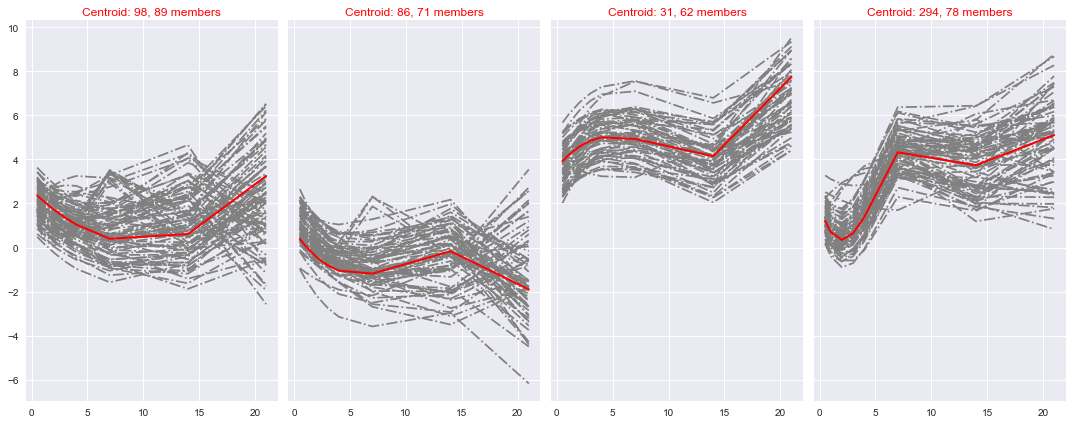

Contingency table (%), d2hat k-medoids:
[[17  8  0  0]
 [ 8 14  0  0]
 [ 2  0 20  1]
 [ 3  1  0 24]]
Number of badly classified FCs: 71/300


In [6]:
# K-medoid clustering of simulated data, case of independent FCs:
K = 4
cl_kmed_sim_1 = Clustering(means=sim_means_1, cov=sim_cov_1,
                           time_points=time_points_1, dist='d2hat',
                           random_gen=random_gen)
(k_clusters_1,
 k_centroids_1,
 k_cost_1) = cl_kmed_sim_1.fc_clustering(K, nb_rep=50, disp_plot=False,
                                         algorithm='k-means-like')
(k_clusters_1,
 k_centroids_1) = reorder_clusters((1, 0, 3, 2), k_clusters_1, k_centroids_1)
cl_kmed_sim_1.plot_clusters(k, k_clusters_1, k_centroids_1)
comp_mat_1 = contingency_matrix(sim_clusters, k_clusters_1)
badly_classified = nb_var-np.diag(comp_mat_1).sum()
print('Contingency table (%), d2hat k-medoids:')
print(np.round(comp_mat_1/nb_var*100).astype(int))
print(f'Number of badly classified FCs: {badly_classified}/{nb_var}')

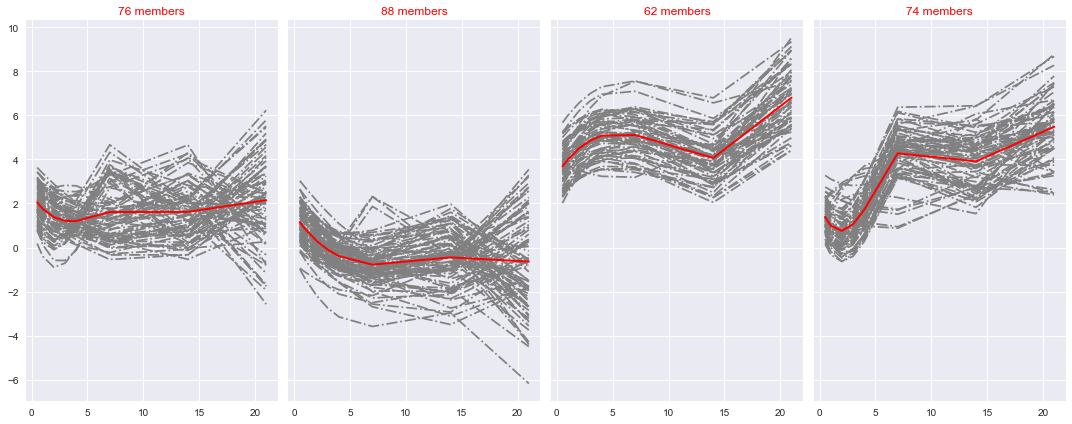

Contingency table (%), Wasserstein k-means:
[[10 14  0  2]
 [ 8 14  0  0]
 [ 1  0 20  2]
 [ 6  1  0 21]]
Number of badly classified FCs: 102/300


In [7]:
# K-means Wasserstein distance based clustering:
cl_kmeans_sim_1 = Clustering(means=sim_means_1, cov=sim_cov_1,
                             time_points=time_points_1, dist='wasserstein',
                             random_gen=random_gen)
(k_clusters_1_w, k_bary_means_1,
 k_bary_cov_1, k_cost_1_w) = cl_kmeans_sim_1.fc_clustering(K, nb_rep=50,
                                                           disp_plot=False,
                                                           method='wass k-means')
no_w = (2, 0, 1, 3)
k_clusters_1_w = reorder_clusters(no_w, k_clusters_1_w)
cl_kmeans_sim_1.plot_clusters(k, k_clusters_1_w, k_bary_means_1[:, no_w],
                              centroid_type='barycenter')
comp_mat_1_w = contingency_matrix(sim_clusters, k_clusters_1_w)
badly_classified = nb_var-np.diag(comp_mat_1_w).sum()
print('Contingency table (%), Wasserstein k-means:')
print(np.round(comp_mat_1_w/nb_var*100).astype(int))
print(f'Number of badly classified FCs: {badly_classified}/{nb_var}')

# Study 2: Time Warping & SBM 
### The effect of alignment

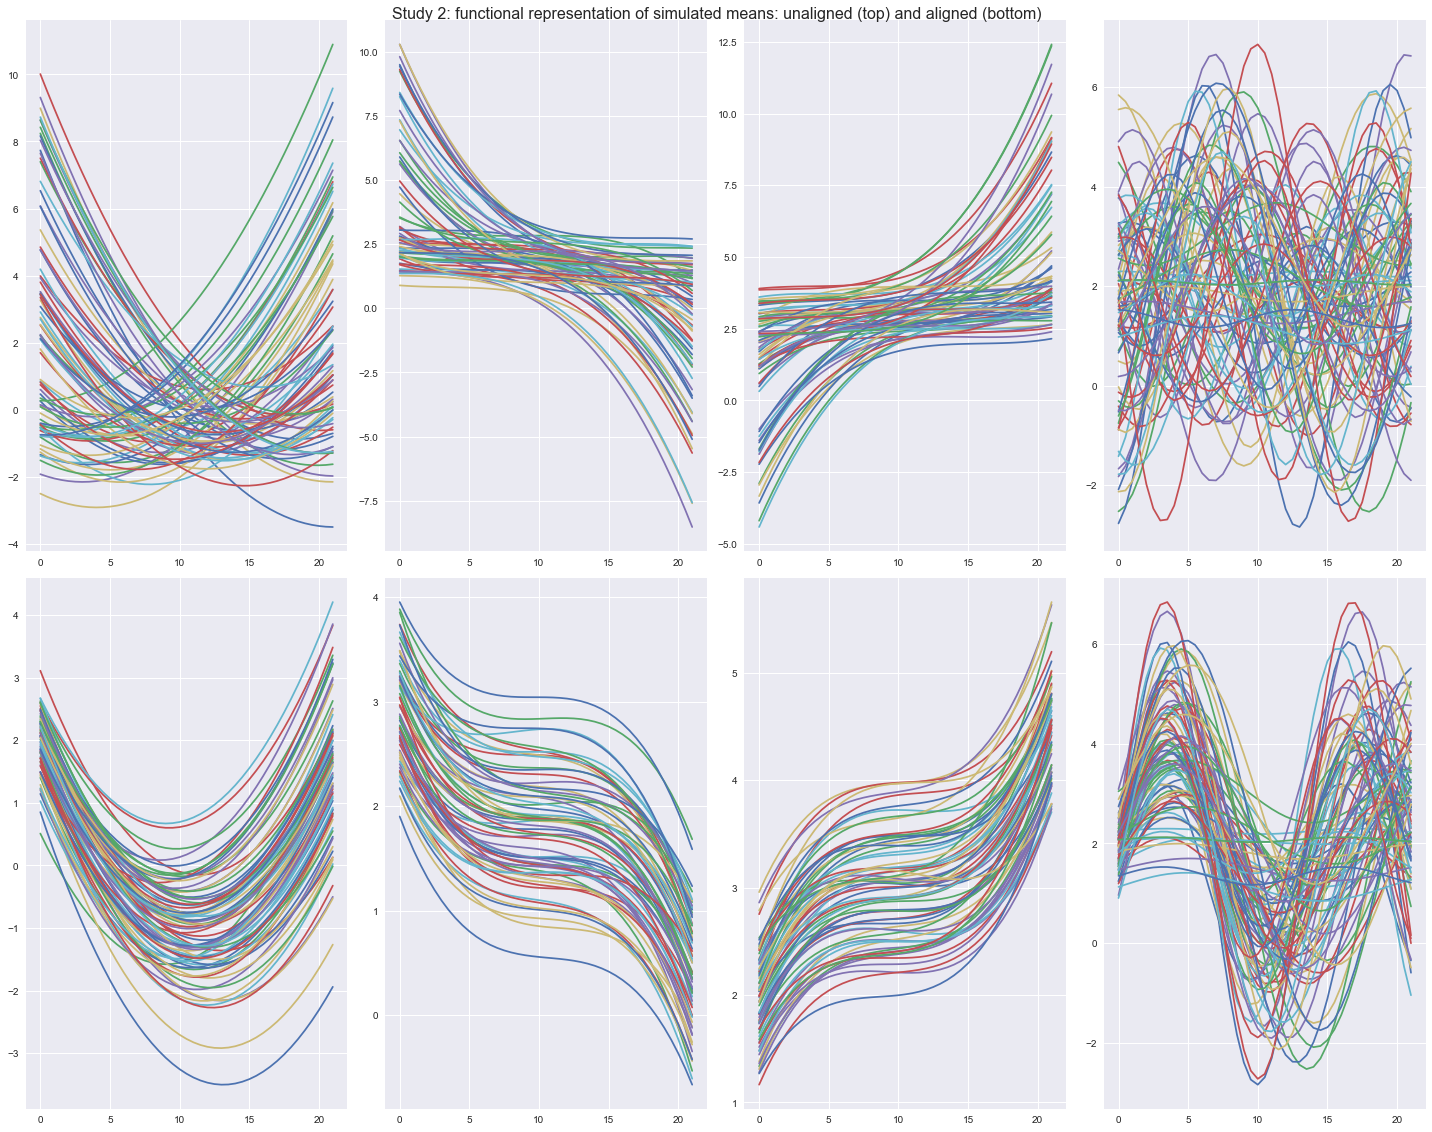

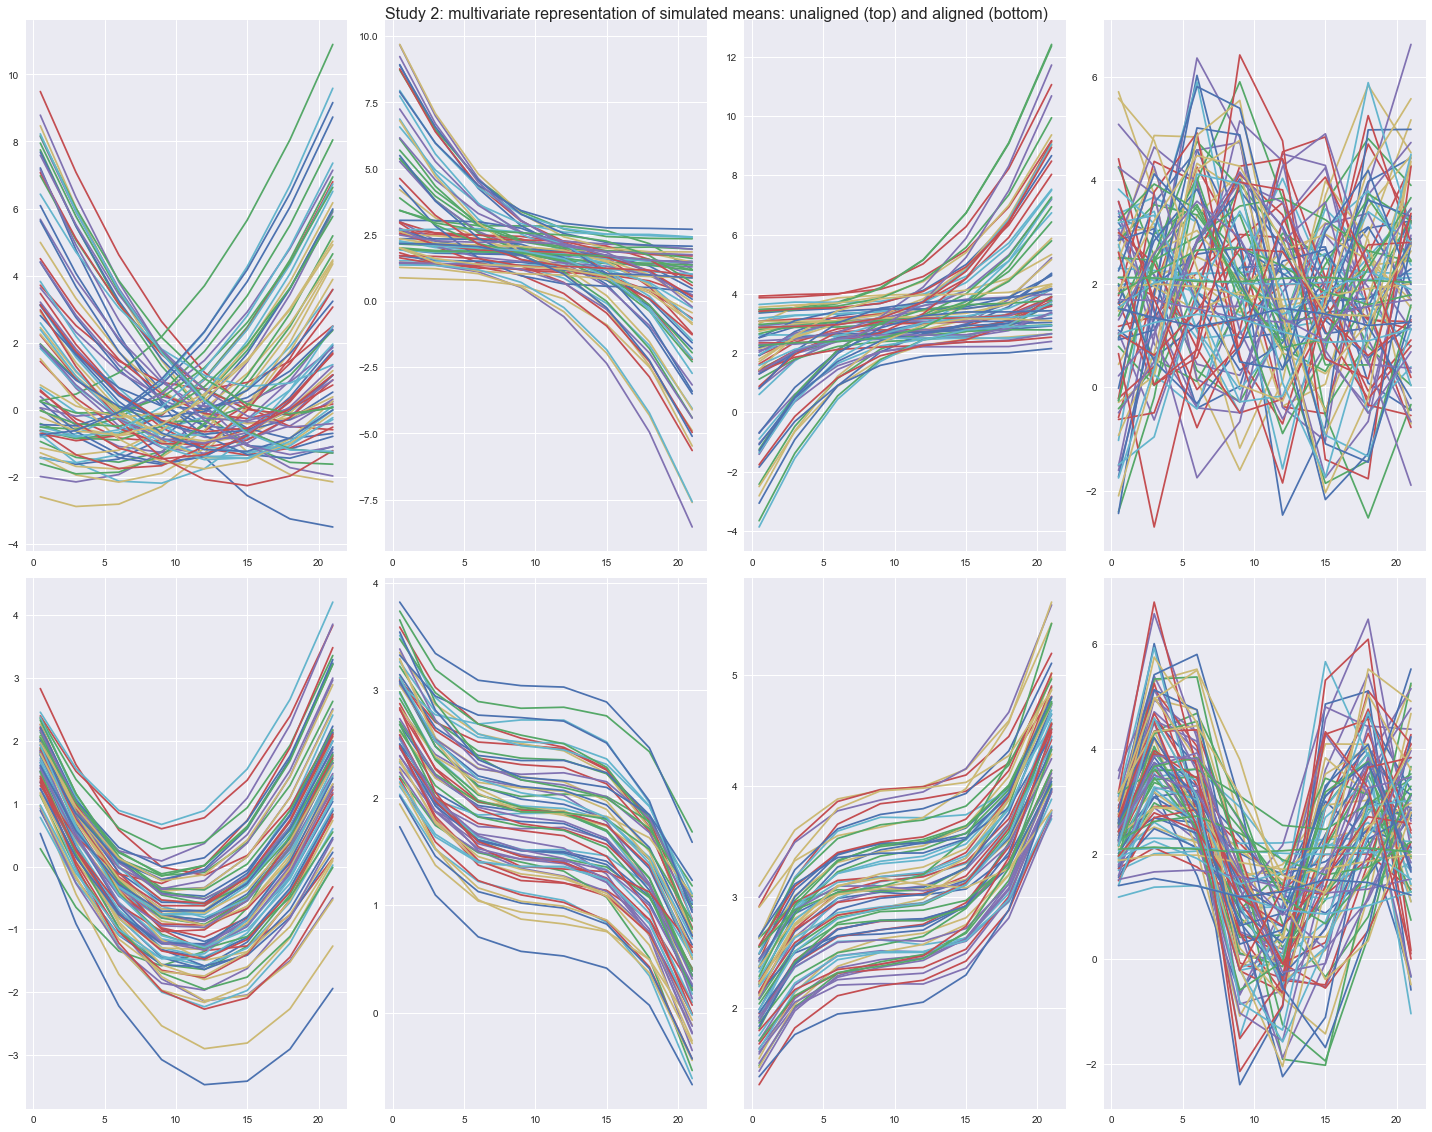

In [8]:
random_gen = np.random.RandomState(10)
# Simulating means of k clusters:
sim_means_2 = np.zeros((nb_time_p, nb_var))
time_p_ind_2 = np.array((1, 6, 12, 18, 24, 30, 36, 42))
time_points_2 = plot_time_points[time_p_ind_2]
fig_1, axs_1 = plt.subplots(2, k, figsize=(20, 16), sharey=False)
fig_2, axs_2 = plt.subplots(2, k, figsize=(20, 16), sharey=False)
for i, cl in enumerate(range(k)):
    cluster_i = np.argwhere(sim_clusters == cl)
    (sim_means_plot_2_ua,
     sim_means_plot_2_a) = simulate_cluster_means_2(cluster_i.size,
                                                    plot_time_points, cl+1,
                                                    random_gen=random_gen)
    axs_1[0][i].plot(plot_time_points, sim_means_plot_2_ua)
    sim_means_2[:, np.squeeze(
        cluster_i)] = sim_means_plot_2_ua[time_p_ind_2, :]
    axs_1[1][i].plot(plot_time_points, sim_means_plot_2_a)
    axs_2[0][i].plot(time_points_2, sim_means_plot_2_ua[time_p_ind_2, :])
    axs_2[1][i].plot(time_points_2, sim_means_plot_2_a[time_p_ind_2, :])

fig_1.suptitle('Study 2: functional representation of simulated means: unaligned (top) and aligned (bottom)',
               fontsize=16)
fig_1.tight_layout()
fig_2.suptitle('Study 2: multivariate representation of simulated means: unaligned (top) and aligned (bottom)',
               fontsize=16)
fig_2.tight_layout()
plt.show()

In [9]:
# Simulating variances of k clusters:
sim_cov_2 = np.zeros((nb_time_p, nb_var, nb_var))
sim_var_2 = np.repeat(np.abs(random_gen.randn(nb_var)),
                      nb_time_p).reshape((nb_var, nb_time_p)).T
sim_cov_2[:, np.arange(nb_var), np.arange(nb_var)] = sim_var_2

### k-medoids:

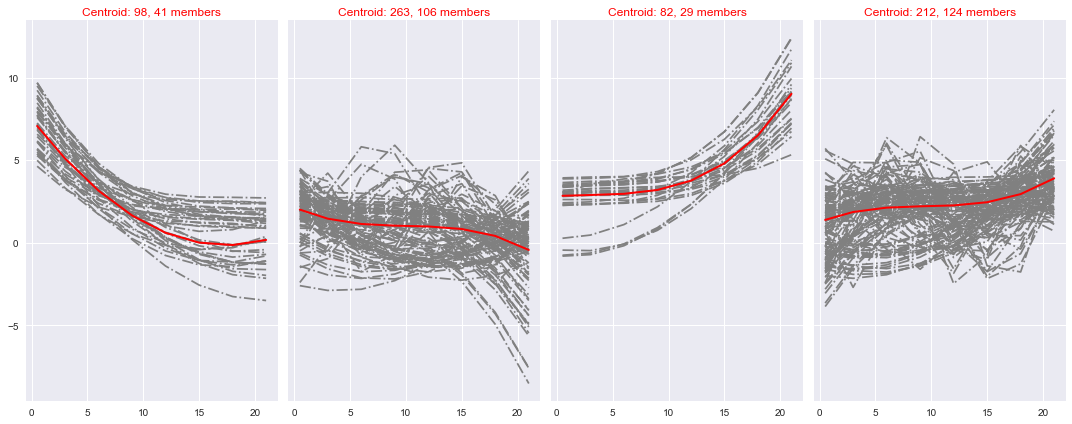

Contingency table (%), d2hat k-medoids (without time warping):
[[ 6 12  1  7]
 [ 7 14  0  1]
 [ 0  0  8 15]
 [ 0  9  0 19]]
Number of badly classified FCs: 157/300


In [10]:
# K-medoid clustering of simulated data WITHOUT time warping, case of independent FCs:
cl_kmed_sim_2 = Clustering(means=sim_means_2, cov=sim_cov_2,
                           time_points=time_points_2, dist='d2hat',
                           random_gen=random_gen)
(k_clusters_2,
 k_centroids_2,
 k_cost_2) = cl_kmed_sim_2.fc_clustering(K, nb_rep=50, disp_plot=False)
(k_clusters_2,
 k_centroids_2) = reorder_clusters((2, 1, 3, 0), k_clusters_2, k_centroids_2)
cl_kmed_sim_2.plot_clusters(k, k_clusters_2, k_centroids_2)
comp_mat_2 = contingency_matrix(sim_clusters, k_clusters_2)
badly_classified = nb_var-np.diag(comp_mat_2).sum()
print('Contingency table (%), d2hat k-medoids (without time warping):')
print(np.round(comp_mat_2/nb_var*100).astype(int))
print(f'Number of badly classified FCs: {badly_classified}/{nb_var}')

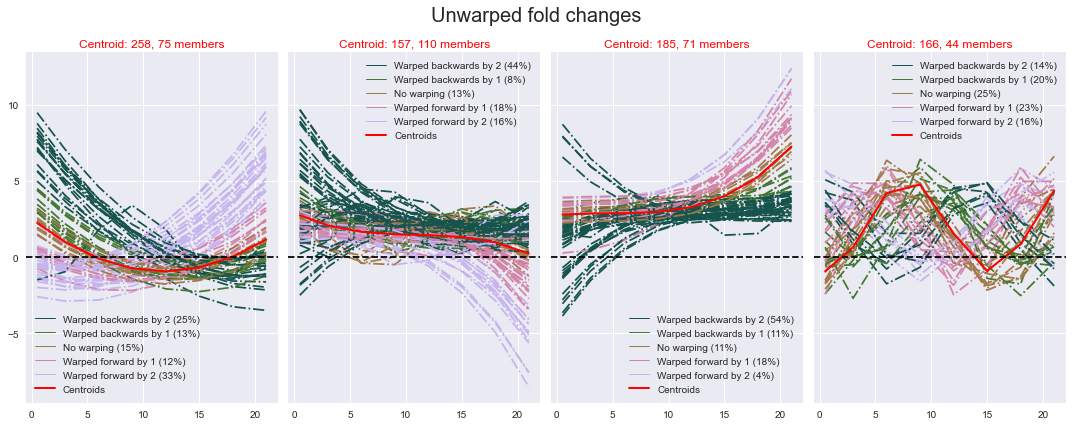

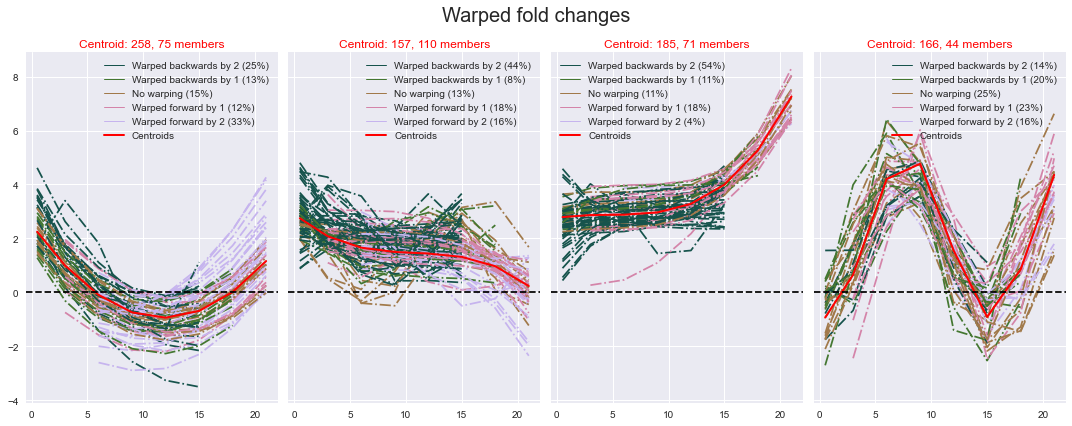

Contingency table (%), d2hat k-medoids (with time warping):
[[25  1  0  0]
 [ 0 21  1  0]
 [ 0  2 21  0]
 [ 0 13  1 15]]
Number of badly classified FCs: 55/300


In [11]:
# K-medoid clustering of simulated data WITH time warping, case of independent FCs:
max_warp_step = 2
cl_kmed_sim_2_tw = Clustering(means=sim_means_2, cov=sim_cov_2,
                              time_points=time_points_2, dist='d2hat',
                              time_warp=True, max_warp_step=max_warp_step,
                              random_gen=random_gen)
(k_clusters_2_tw,
 k_centroids_2_tw,
 k_warps_2,
 k_cost_2_tw) = cl_kmed_sim_2_tw.fc_clustering(K, nb_rep=50, disp_plot=False)
(k_clusters_2_tw,
 k_centroids_2_tw) = reorder_clusters((2, 0, 1, 3), k_clusters_2_tw,
                                      k_centroids_2_tw)
cl_kmed_sim_2_tw.plot_clusters(k, k_clusters_2_tw, k_centroids_2_tw,
                               warps=k_warps_2)
comp_mat_2_tw = contingency_matrix(sim_clusters, k_clusters_2_tw)
badly_classified = nb_var-np.diag(comp_mat_2_tw).sum()
print('Contingency table (%), d2hat k-medoids (with time warping):')
print(np.round(comp_mat_2_tw/nb_var*100).astype(int))
print(f'Number of badly classified FCs: {badly_classified}/{nb_var}')

### SBM:

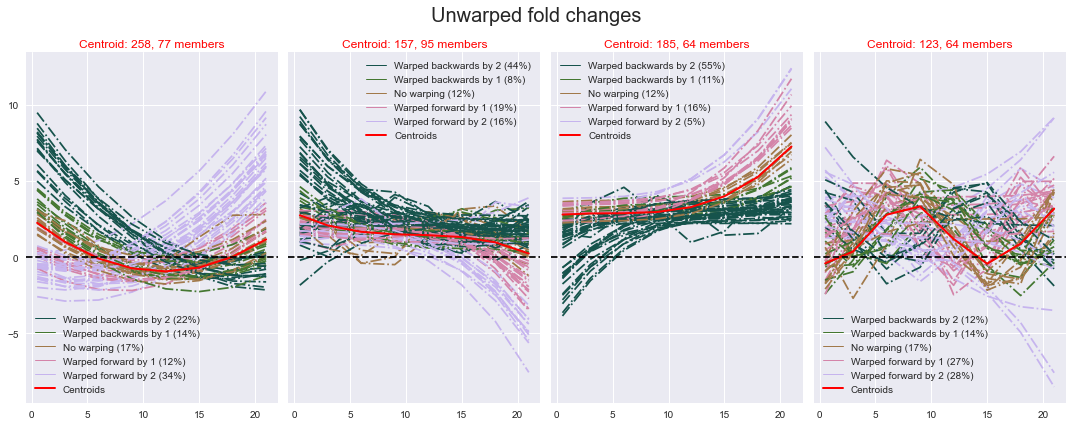

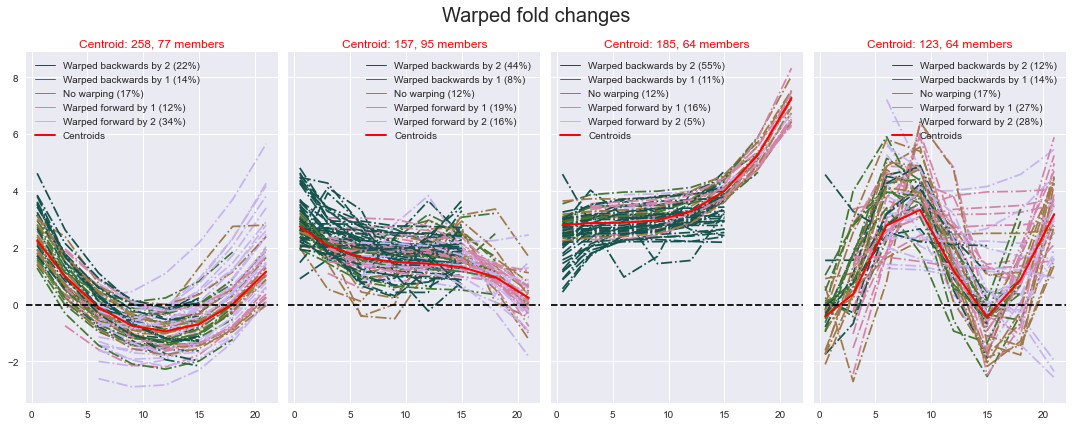

Contingency table (%), d2hat k-medoids-based SBM:
[[25  1  0  0]
 [ 0 20  0  2]
 [ 0  1 20  2]
 [ 0 10  1 16]]
Number of badly classified FCs: 55/300


In [12]:
rand_seed = 459
random_gen = np.random.RandomState(rand_seed)

sparsity = 0.8
sim_net = NetworkInference(means=sim_means_2, cov=sim_cov_2,
                           time_points=time_points_2, dist='d2hat',
                           time_warp=True, max_warp_step=max_warp_step,
                           sparsity=sparsity, random_gen=random_gen)
n_init = 3

# SBM initialized from k-medoids:
(sbm_sim,
 sbm_sim_centroids,
 sbm_sim_comp_cost) = sim_net.infer_sbm(k, k_clusters_2_tw, n_init=n_init,
                                        verbosity=0, pi_weight=0.8,
                                        random_gen=random_gen)
clusters_sbm = sbm_sim.labels
corresp_centr = sbm_sim_centroids[clusters_sbm]
sbm_sim_warps = sim_net.optimal_warp_mat[np.arange(0, nb_var), corresp_centr]
cl_kmed_sim_2_tw.plot_clusters(k, clusters_sbm, sbm_sim_centroids,
                               warps=sbm_sim_warps, nb_cols=k,
                               nb_rows=1, figsize=(15, 6))
comp_mat_sbm = contingency_matrix(sim_clusters, clusters_sbm)
badly_classified = nb_var-np.diag(comp_mat_sbm).sum()
print('Contingency table (%), d2hat k-medoids-based SBM:')
print(np.round(comp_mat_sbm/nb_var*100).astype(int))
print(f'Number of badly classified FCs: {badly_classified}/{nb_var}')

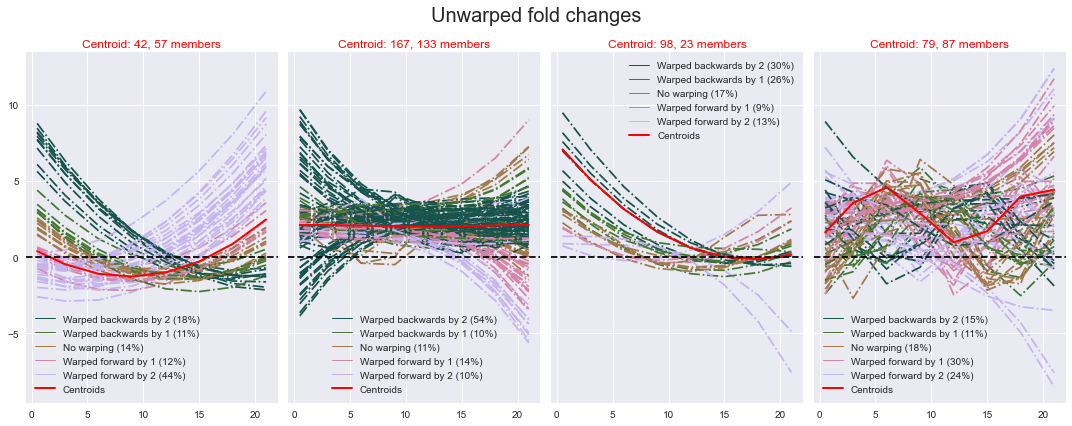

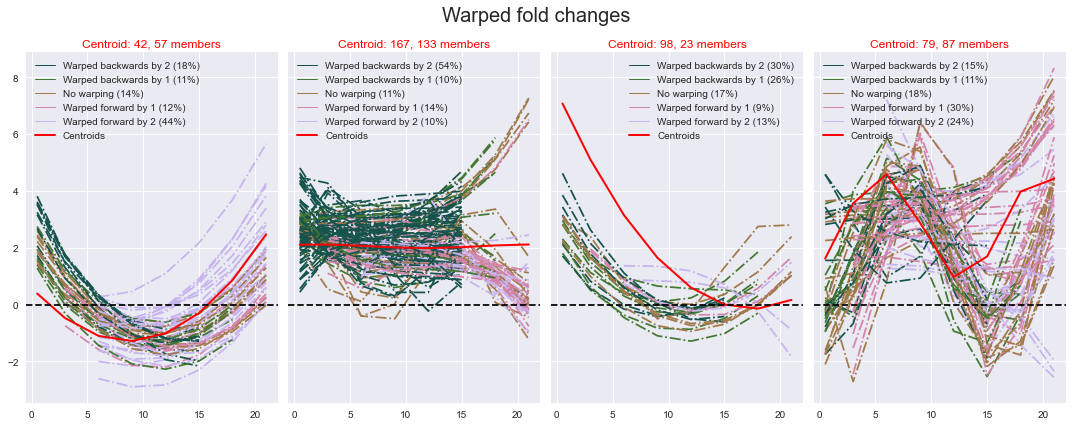

Contingency table (%), unconstrained SBM:
[[19  1  6  0]
 [ 0 19  1  2]
 [ 0 14  0  9]
 [ 0 11  0 17]]
Number of badly classified FCs: 135/300


In [13]:
# SBM based on random initializations:
(sbm_sim_random,
 sbm_sim_centroids_random,
 sbm_sim_comp_cost_random) = sim_net.infer_sbm(k, k_clusters_2_tw,
                                               n_init=n_init, verbosity=0,
                                               random=True,
                                               random_gen=random_gen)
clusters_sbm_random = sbm_sim_random.labels
(clusters_sbm_random,
 sbm_sim_centroids_random) = reorder_clusters((1, 0, 2, 3),
                                              clusters_sbm_random,
                                              sbm_sim_centroids_random)
cl_kmed_sim_2_tw.plot_clusters(k, clusters_sbm_random,
                               sbm_sim_centroids_random,
                               warps=sbm_sim_warps, nb_cols=k,
                               nb_rows=1, figsize=(15, 6))
comp_mat_sbm_rand = contingency_matrix(sim_clusters, clusters_sbm_random)
badly_classified = nb_var-np.diag(comp_mat_sbm_rand).sum()
print('Contingency table (%), unconstrained SBM:')
print(np.round(comp_mat_sbm_rand/nb_var*100).astype(int))
print(f'Number of badly classified FCs: {badly_classified}/{nb_var}')

### UMAP:

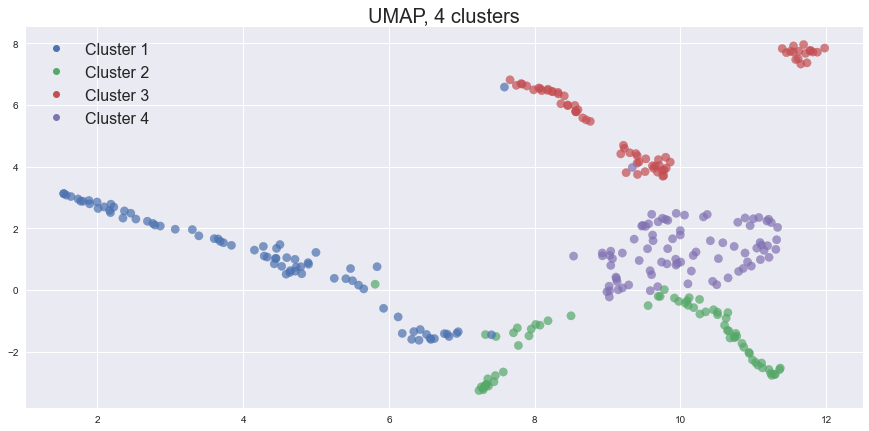

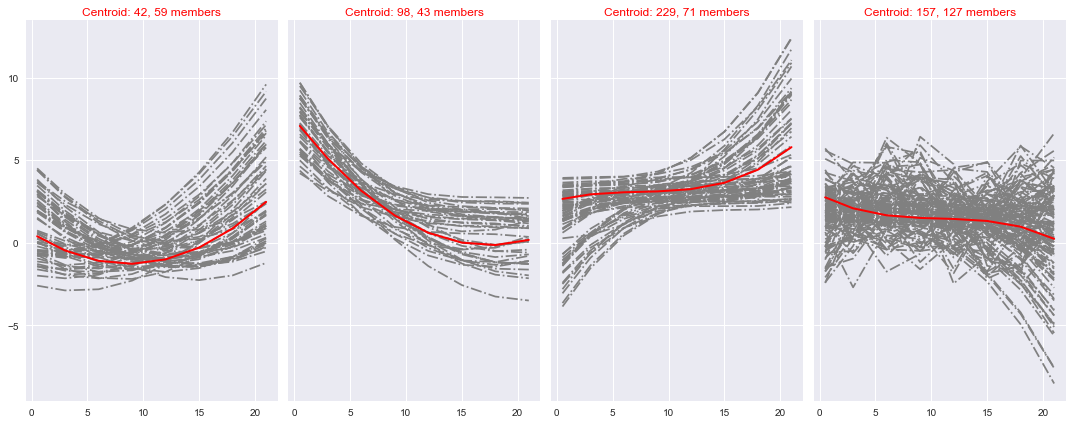

Contingency table (%), UMAP + k-means (without time warping):
[[20  6  0  0]
 [ 0  8  0 14]
 [ 0  0 23  0]
 [ 0  0  0 28]]
Number of badly classified FCs: 64/300


In [14]:
# K-means clustering of the UMAP of the d2hat distance matrix (no tw):
(k_clusters_2_umap,
 k_centroids_2_umap) = cl_kmed_sim_2.fc_clustering(K, nb_rep=50, disp_plot=True,
                                                   method='umap',
                                                   umap_color_labels=sim_clusters)
(k_clusters_2_umap,
 k_centroids_2_umap) = reorder_clusters((3, 0, 1, 2), k_clusters_2_umap,
                                        k_centroids_2_umap)
cl_kmed_sim_2.plot_clusters(k, k_clusters_2_umap, k_centroids_2_umap)

comp_mat_2_umap = contingency_matrix(sim_clusters, k_clusters_2_umap)
badly_classified = nb_var-np.diag(comp_mat_2_umap).sum()
print('Contingency table (%), UMAP + k-means (without time warping):')
print(np.round(comp_mat_2_umap/nb_var*100).astype(int))
print(f'Number of badly classified FCs: {badly_classified}/{nb_var}')

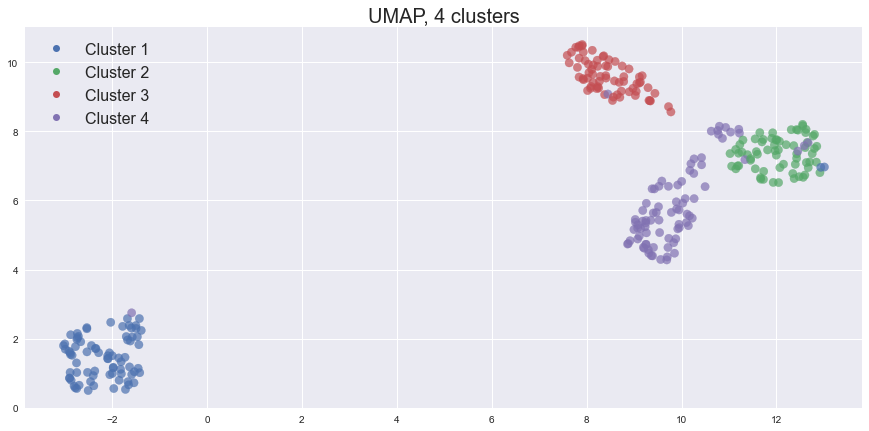

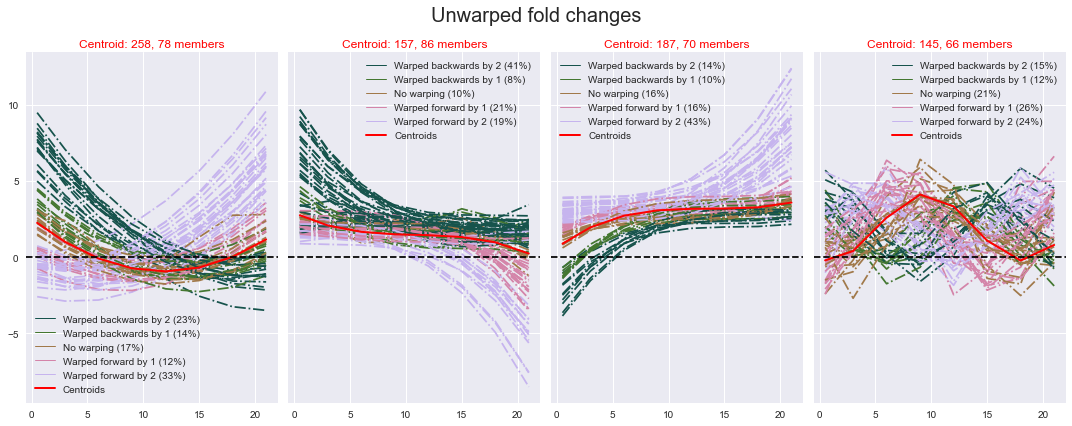

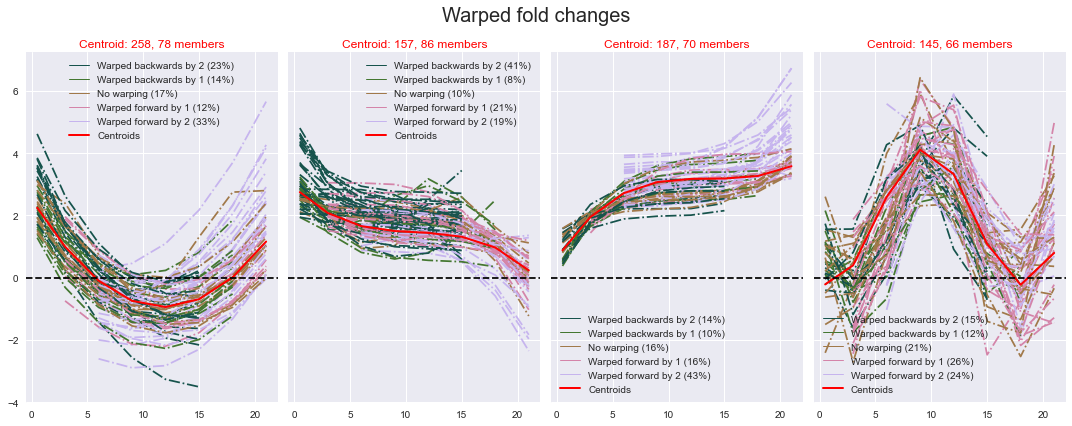

Contingency table (%), UMAP + k-means (with time warping):
[[26  1  0  0]
 [ 0 22  0  0]
 [ 0  0 23  0]
 [ 0  6  0 22]]
Number of badly classified FCs: 21/300


In [15]:
# K-means clustering of the UMAP of the d2hat distance matrix (with tw):
(k_clusters_2_umap_tw,
 k_centroids_2_umap_tw,
 k_warps_2_umap) = cl_kmed_sim_2_tw.fc_clustering(K, nb_rep=50, disp_plot=True,
                                                  method='umap',
                                                  umap_color_labels=sim_clusters)
cl_kmed_sim_2_tw.plot_clusters(k, k_clusters_2_umap_tw, k_centroids_2_umap_tw,
                               warps=k_warps_2_umap)
comp_mat_2_umap_tw = contingency_matrix(sim_clusters, k_clusters_2_umap_tw)
badly_classified = nb_var-np.diag(comp_mat_2_umap_tw).sum()
print('Contingency table (%), UMAP + k-means (with time warping):')
print(np.round(comp_mat_2_umap_tw/nb_var*100).astype(int))
print(f'Number of badly classified FCs: {badly_classified}/{nb_var}')